# <center> CSM </center>
##  <center> Trabalho Prático 3 </center>


---

In [1]:
# IMPORTS
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2
from time import time
from os import path
import re
# import pandas as pd
import numpy.random as rd
import array as arr
import os

---

## Introdução


A compressão de imagens é uma técnica fundamental para reduzir o tamanho dos arquivos de imagem, tornando mais eficiente o armazenamento e a transmissão desses dados visuais.  

O objetivo deste trabalho é implementar e analisar o desempenho de um codificador/descodificador JPEG sequencial para a compressão de imagens em tons de cinza. O uso de imagens em tons de cinza é relevante em várias aplicações, como fotografias, imagens médicas e documentos digitalizados, onde a cor não é um fator crucial.  

A codificação JPEG consiste em várias etapas, como a partição de uma imagem em blocos 8x8, a aplicação da DCT a cada bloco, a quantificação dos coeficientes DC e AC e a criação de um arquivo comprimido. Por outro lado, o processo de descodificação envolve a leitura do arquivo comprimido, a descompressão dos coeficientes quantificados, a aplicação da DCT inversa e a reconstrução da imagem original.  

No final deste trabalho, espera-se que sejam identificados os benefícios e as limitações da codificação JPEG sequencial para compressão de imagens a tons de cinza, bem como possíveis melhorias e otimizações para futuros trabalhos.

---

## Código fornecido

In [2]:
# Tabelas da norma ITU T.81 - JPEG standa

# tabela K1 - Luminance quantize Matrix  
Q = np.zeros((8, 8))
Q[0] = [ 16,  11,  10,  16,  24,  40,  51,  61]
Q[1] = [ 12,  12,  14,  19,  26,  58,  60,  55]
Q[2] = [ 14,  13,  16,  24,  40,  57,  69,  56]
Q[3] = [ 14,  17,  22,  29,  51,  87,  80,  62]
Q[4] = [ 18,  22,  37,  56,  68, 109, 103,  77]
Q[5] = [ 24,  35,  55,  64,  81, 104, 113,  92]
Q[6] = [ 49,  64,  78,  87, 103, 121, 120, 101]
Q[7] = [ 72,  92,  95,  98, 112, 100, 103,  99]

# Tabela K3 
# Table for luminance DC coefficient differences
K3 = dict()
K3[0] = "00"
K3[1] = "010"
K3[2] = "011"
K3[3] = "100"
K3[4] = "101"
K3[5] = "110"
K3[6] = "1110"
K3[7] = "11110"
K3[8] = "111110"
K3[9] = "1111110"
K3[10] = "11111110"
K3[11] = "111111110"

# Tabela K5 
# Table for luminance AC coefficients
K5 = dict()
K5[(0, 0)] = "1010"
K5[(0, 1)] = "00"
K5[(0, 2)] = "01"
K5[(0, 3)] = "100"
K5[(0, 4)] = "1011"
K5[(0, 5)] = "11010"
K5[(0, 6)] = "1111000"
K5[(0, 7)] = "11111000"
K5[(0, 8)] = "1111110110"
K5[(0, 9)] = "1111111110000010"
K5[(0,10)] = "1111111110000011"

K5[(1, 1)] = "1100"
K5[(1, 2)] = "11011"
K5[(1, 3)] = "1111001"
K5[(1, 4)] = "111110110"
K5[(1, 5)] = "11111110110"
K5[(1, 6)] = "1111111110000100"
K5[(1, 7)] = "1111111110000101"
K5[(1, 8)] = "1111111110000110"
K5[(1, 9)] = "1111111110000111"
K5[(1,10)] = "1111111110001000"

K5[(2, 1)] = "11100"
K5[(2, 2)] = "11111001"
K5[(2, 3)] = "1111110111"
K5[(2, 4)] = "111111110100"
K5[(2, 5)] = "1111111110001001"
K5[(2, 6)] = "1111111110001010"
K5[(2, 7)] = "1111111110001011"
K5[(2, 8)] = "1111111110001100"
K5[(2, 9)] = "1111111110001101"
K5[(2,10)] = "1111111110001110"

K5[(3, 1)] = "111010"
K5[(3, 2)] = "111110111"
K5[(3, 3)] = "111111110101"
K5[(3, 4)] = "1111111110001111"
K5[(3, 5)] = "1111111110010000"
K5[(3, 6)] = "1111111110010001"
K5[(3, 7)] = "1111111110010010"
K5[(3, 8)] = "1111111110010011"
K5[(3, 9)] = "1111111110010100"
K5[(3,10)] = "1111111110010101"

K5[(4, 1)] = "111011"
K5[(4, 2)] = "1111111000"
K5[(4, 3)] = "1111111110010110"
K5[(4, 4)] = "1111111110010111"
K5[(4, 5)] = "1111111110011000"
K5[(4, 6)] = "1111111110011001"
K5[(4, 7)] = "1111111110011010"
K5[(4, 8)] = "1111111110011011"
K5[(4, 9)] = "1111111110011100"
K5[(4,10)] = "1111111110011101"

K5[(5, 1)] = "1111010"
K5[(5, 2)] = "11111110111"
K5[(5, 3)] = "1111111110011110"
K5[(5, 4)] = "1111111110011111"
K5[(5, 5)] = "1111111110100000"
K5[(5, 6)] = "1111111110100001"
K5[(5, 7)] = "1111111110100010"
K5[(5, 8)] = "1111111110100011"
K5[(5, 9)] = "1111111110100100"
K5[(5,10)] = "1111111110100101"

K5[(6, 1)] = "1111011"
K5[(6, 2)] = "111111110110"
K5[(6, 3)] = "1111111110100110"
K5[(6, 4)] = "1111111110100111"
K5[(6, 5)] = "1111111110101000"
K5[(6, 6)] = "1111111110101001"
K5[(6, 7)] = "1111111110101010"
K5[(6, 8)] = "1111111110101011"
K5[(6, 9)] = "1111111110101100"
K5[(6,10)] = "1111111110101101"

K5[(7, 1)] = "11111010"
K5[(7, 2)] = "111111110111"
K5[(7, 3)] = "1111111110101110"
K5[(7, 4)] = "1111111110101111"
K5[(7, 5)] = "1111111110110000"
K5[(7, 6)] = "1111111110110001"
K5[(7, 7)] = "1111111110110010"
K5[(7, 8)] = "1111111110110011"
K5[(7, 9)] = "1111111110110100"
K5[(7,10)] = "1111111110110101"

K5[(8, 1)] = "111111000"
K5[(8, 2)] = "111111111000000"
K5[(8, 3)] = "1111111110110110"
K5[(8, 4)] = "1111111110110111"
K5[(8, 5)] = "1111111110111000"
K5[(8, 6)] = "1111111110111001"
K5[(8, 7)] = "1111111110111010"
K5[(8, 8)] = "1111111110111011"
K5[(8, 9)] = "1111111110111100"
K5[(8,10)] = "1111111110111101"

K5[(9, 1)] = "111111001"
K5[(9, 2)] = "1111111110111110"
K5[(9, 3)] = "1111111110111111"
K5[(9, 4)] = "1111111111000000"
K5[(9, 5)] = "1111111111000001"
K5[(9, 6)] = "1111111111000010"
K5[(9, 7)] = "1111111111000011"
K5[(9, 8)] = "1111111111000100"
K5[(9, 9)] = "1111111111000101"
K5[(9,10)] = "1111111111000110"

K5[(10, 1)] = "111111010"
K5[(10, 2)] = "1111111111000111"
K5[(10, 3)] = "1111111111001000"
K5[(10, 4)] = "1111111111001001"
K5[(10, 5)] = "1111111111001010"
K5[(10, 6)] = "1111111111001011"
K5[(10, 7)] = "1111111111001100"
K5[(10, 8)] = "1111111111001101"
K5[(10, 9)] = "1111111111001110"
K5[(10,10)] = "1111111111001111"

K5[(11, 1)] = "1111111001"
K5[(11, 2)] = "1111111111010000"
K5[(11, 3)] = "1111111111010001"
K5[(11, 4)] = "1111111111010010"
K5[(11, 5)] = "1111111111010011"
K5[(11, 6)] = "1111111111010100"
K5[(11, 7)] = "1111111111010101"
K5[(11, 8)] = "1111111111010110"
K5[(11, 9)] = "1111111111010111"
K5[(11,10)] = "1111111111011000"

K5[(12, 1)] = "1111111010"
K5[(12, 2)] = "1111111111011001"
K5[(12, 3)] = "1111111111011010"
K5[(12, 4)] = "1111111111011011"
K5[(12, 5)] = "1111111111011100"
K5[(12, 6)] = "1111111111011101"
K5[(12, 7)] = "1111111111011110"
K5[(12, 8)] = "1111111111011111"
K5[(12, 9)] = "1111111111100000"
K5[(12,10)] = "1111111111100001"

K5[(13, 1)] = "11111111000"
K5[(13, 2)] = "1111111111100010"
K5[(13, 3)] = "1111111111100011"
K5[(13, 4)] = "1111111111100100"
K5[(13, 5)] = "1111111111100101"
K5[(13, 6)] = "1111111111100110"
K5[(13, 7)] = "1111111111100111"
K5[(13, 8)] = "1111111111101000"
K5[(13, 9)] = "1111111111101001"
K5[(13,10)] = "1111111111101010"

K5[(14, 1)] = "1111111111101011"
K5[(14, 2)] = "1111111111101100"
K5[(14, 3)] = "1111111111101101"
K5[(14, 4)] = "1111111111101110"
K5[(14, 5)] = "1111111111101111"
K5[(14, 6)] = "1111111111110000"
K5[(14, 7)] = "1111111111110001"
K5[(14, 8)] = "1111111111110010"
K5[(14, 9)] = "1111111111110011"
K5[(14,10)] = "1111111111110100"

K5[(15, 0)] = "11111111001"
K5[(15, 1)] = "1111111111110101"
K5[(15, 2)] = "1111111111110110"
K5[(15, 3)] = "1111111111110111"
K5[(15, 4)] = "1111111111111000"
K5[(15, 5)] = "1111111111111001"
K5[(15, 6)] = "1111111111111010"
K5[(15, 7)] = "1111111111111011"
K5[(15, 8)] = "1111111111111100"
K5[(15, 9)] = "1111111111111101"
K5[(15,10)] = "1111111111111110"

# ordem zig-zag 
zigzag = np.zeros((8, 8))
zigzag[0] = [ 0,  1,  5,  6, 14, 15, 27, 28]
zigzag[1] = [ 2,  4,  7, 13, 16, 26, 29, 42]
zigzag[2] = [ 3,  8, 12, 17, 25, 30, 41, 43]
zigzag[3] = [ 9, 11, 18, 24, 31, 40, 44, 53]
zigzag[4] = [10, 19, 23, 32, 39, 45, 52, 54]
zigzag[5] = [20, 22, 33, 38, 46, 51, 55, 60]
zigzag[6] = [21, 34, 37, 47, 50, 56, 59, 61]
zigzag[7] = [35, 36, 48, 49, 57, 58, 62, 63]
zigzag=zigzag.astype('int16')
ind_zz = zigzag.reshape((64),order='F').astype('int16')

##########################################################################
#
#   Função para calcular o valor a multiplicar  a tabela K1 a
#   partir do fator de qualidade
#
##########################################################################

def quality_factor(q):
    if(q <= 50):
        factor = 50.0 / q
    else:
        factor = 2.0 - (q * 2.0)/100.0
    return factor 



---

## Funções Auxiliares

In [3]:
def get_file(f):
    return np.fromfile(f, dtype='uint8')

def comp_rate(x, y):

    return os.path.getsize(x)/os.path.getsize(y)

def entropy(prob): 
    """
    @param prob: probabilidades dos símbolos da mensagem
    @return: entropia da fonte
    """
    return -np.dot(prob, np.log2(prob))  

def eficiency(L, entropy):
    """
    @param L: número médio de bits por símbolo
    @param entropy: entropia da fonte
    @return: eficiencia
    """
    return entropy / L

def avg_bits_per_simb(prob, ht):
    """
    @param prob: probabilidades dos símbolos
    @param ht: tabela de huffman
    @return: número médio de bits por símbolo
    """
    # tamanho do código de cada símbolo
    l = np.array([len(i) for i in list(ht.values())])
    return np.dot(prob, l)

def SNR(img_original, img_comp):
    """
    Método que calcula a relação sinal ruído 
    entre um ficheiro original e este ficheiro 
    comprimido
    """
    e   = img_original*1.0 - img_comp*1.0
    Px  = np.mean((img_original*1.0)**2)
    Pe  = np.mean((e*1.0)**2)
    SNR = 10 * np.log10(Px/Pe)
    
    return SNR

def PSNR(img_original, img_comp):
    """
    Método que calcula o Peak signal-to-noise ratio
    entre um ficheiro original e este ficheiro 
    comprimido
    """
    e    = img_original*1.0 - img_comp*1.0
    Px   = 255**2
    Pe   = np.mean((e*1.0)**2)
    PSNR = 10 * np.log10(Px/Pe)
    
    return PSNR

### Pixel Stuffing
O pixel stuffing é uma técnica que insere pixeis extra numa imagem em que as linhas ou as colunas não são divisíveis por 8. Caso não sejam divisíveis por 8 (resto da divisão diferente de 0), é replicada a última linha ou coluna, até a dimensão da imagem ser divisível por 8.

In [4]:
def pixel_stuffing(img):
    """
    @param img: Imagem a aplicar o pixel stuffing
    """
    
    lin, col = img.shape

    if lin % 8 != 0:
        img = np.append(img, np.array([img[-1]]), axis=0)
        
    elif col % 8 != 0:
        new_img = np.zeros((lin, col+1)) 
        for i in range(len(img)):
            new_img[i] = np.append(img[i], np.array([img[i][-1]]))
        img = new_img.astype(int)
     
    # Condição de paragem da recursividade - se a dimensão já for divisível por 8
    elif lin % 8 == 0 and col % 8 == 0: 
        return img
    
    return pixel_stuffing(img) # recursividade(repete o processo de adição de linhas/colunas até ser divisivel)

#### Testes ao pixel stuffing

In [5]:
# LINHAS
ps_teste_linhas = rd.randint(0, 255,(6,8))
aplicar_ps = pixel_stuffing(ps_teste_linhas)

print('Array teste (6 linhas):' )
print(ps_teste_linhas)
print('Array pixel stuffing (linhas):')
print(aplicar_ps)

# COLUNAS
ps_teste_colunas = rd.randint(0, 255,(8,6))
aplicar_ps2 = pixel_stuffing(ps_teste_colunas)

print('Array teste (6 colunas):')
print(ps_teste_colunas)
display('Array pixel stuffing (colunas)')
print(aplicar_ps2)

Array teste (6 linhas):
[[100  64 158 190 149 112 158  79]
 [115 240  80 181 110  74 107 233]
 [172 162 194 138 232 152 116 183]
 [162  82 153 182 215 245 135 159]
 [192  17  16 175  53 113  18  27]
 [201  71 173  19  41  58  18 224]]
Array pixel stuffing (linhas):
[[100  64 158 190 149 112 158  79]
 [115 240  80 181 110  74 107 233]
 [172 162 194 138 232 152 116 183]
 [162  82 153 182 215 245 135 159]
 [192  17  16 175  53 113  18  27]
 [201  71 173  19  41  58  18 224]
 [201  71 173  19  41  58  18 224]
 [201  71 173  19  41  58  18 224]]
Array teste (6 colunas):
[[180  95  75  38 101 208]
 [131   9 102 131  11  65]
 [129 183 108  74  26 168]
 [104 177  24 252  36 240]
 [ 75 234   3  26 119 193]
 [117 128  29 146 237 249]
 [199 217 166  32 250  63]
 [222 216 107 134 182  19]]


'Array pixel stuffing (colunas)'

[[180  95  75  38 101 208 208 208]
 [131   9 102 131  11  65  65  65]
 [129 183 108  74  26 168 168 168]
 [104 177  24 252  36 240 240 240]
 [ 75 234   3  26 119 193 193 193]
 [117 128  29 146 237 249 249 249]
 [199 217 166  32 250  63  63  63]
 [222 216 107 134 182  19  19  19]]


### Blocos 8x8
Divisão de uma imagem em blocos 8x8

In [6]:
def blocks_8x8(array):
    resultado = []
    for i in range(0, array.shape[0], 8):
        for j in range(0, array.shape[1], 8):
            bloco = array[i:i+8, j:j+8]
            resultado.append(bloco)
    return np.array(resultado)

In [7]:
def convert_blocks8x8(blocks, linhas, colunas):
    
    imagem = np.zeros((linhas, colunas), dtype=int)

    dimensao = imagem.shape
    index = 0
    for i in range(0,dimensao[0],8):
        for j in range(0,dimensao[1],8):
            imagem[i: i + 8, j: j + 8] = blocks[index]
            index += 1

    imagem = np.array(imagem)
    return imagem

In [8]:
def bit_stuffing(msg):
    
    if(((3 + len(msg)) % 8) == 0): 
        msg = '000' + msg

    else:
        resto = 8 -((3 + len(msg)) % 8) #quantidades de bits a acrescentar
        quant = np.binary_repr(resto, 3) # 3 bits -> 0-7
        zeros = '0' * resto
        msg = quant + zeros + msg
    
    return msg

In [9]:
blocos_teste = rd.randint(0, 255, (16,16))
aplicar_blocos = blocks_8x8(blocos_teste)

print('Array teste:')
print(blocos_teste)
print('Blocos:')
print(aplicar_blocos)
linhas, colunas = blocos_teste.shape
desfazer_blocos = convert_blocks8x8(aplicar_blocos,linhas,colunas)

print('Array teste:')
print(blocos_teste)
print('Array sem blocos:')
print(desfazer_blocos)

Array teste:
[[189 103  67  11  31 110  42  79 213 181 109   7 249 248 193  19]
 [109  88 252  64 190 100 169 129 212 189 252  10 246  69 209 112]
 [ 97  43  98  64  34 114  96  76  74 238 165 165  48 243  85  76]
 [128   0 122  60   5  83 114 144 232  81 254  96 137 253 152 121]
 [236 166 124 245  85  29 222 200 217  28  28 204 185 174 160 242]
 [206 249  12  38 133  72 246 102 109 228 127 114 245 141  39 172]
 [ 30 140  52 215  84 187 109 232 135  48 120  79  42   7  95  94]
 [157 169  78 146 127 215 241  75 141 106 174 140 132 254 170  37]
 [131 161 160 138  22  91   7 122 242 213  89 206  76 158 228  37]
 [ 99 101 143  72  79  26 128 108 163 228  97 227 238  36 184 207]
 [157 194  32  56 153 154 188 163  97  67  85  50  29 190  12  92]
 [175 122 213  53 224 228 225 223  68 128 124 214  88  73 163  48]
 [208 253   8 169  68   5  44  89  57  15 247  15  37  71 249 178]
 [148  76  61 162 239  74  23  96 186  56  31  30 246 236  63  95]
 [150  32  19 101 141 130 202  93  48 112  15  14

In [10]:
def aplicar_zigzag(arr, idx):
    """
    @param arr: array a aplicar zigzag
    @param idx: indices do zigzag
    """
    zi  = np.argsort(idx)
    arr = arr.reshape(64, order = 'F') #F ordena pelas colunas(primeira, segunda, terceira...)
    
    return arr[zi]

In [11]:
def desfazer_zigzag(arr, idx):
    arr = arr[idx]
    return arr.reshape((8,8),order='F')

In [12]:
def DC_AC(img_DC, img_AC):
    count = 0
    for val in img_DC:
        img_AC[count][0][0] = val
        count = count + 1
    return img_AC

---

### Exercício 1
Construa uma função (codificador) que para cada bloco de 8×8 da imagem original efetue a DCT bidimensional
e construa outra função (descodificador) que faça a DCT inversa. Ver funções: cv2.dct() e cv2.idct())
Visualize a imagem depois da DCT e verifique que a DCT inversa resulta na imagem original.

* ***cv2.dct()***: 

é uma função Python da biblioteca OpenCV que executa uma Transformada Cosseno Discreta (DCT) 2D numa matriz de entrada fornecida.  

A DCT é uma técnica usada em processamento de sinais e compressão de imagens para transformar um sinal ou uma imagem do domínio espacial para o domínio de frequência. Os coeficientes de DCT resultantes representam os componentes de frequência da imagem, que podem ser usados para reduzir a quantidade de dados necessários para armazenar a imagem, preservando a maioria das características importantes.  

* ***cv2.idct()***:  

é uma função Python da biblioteca OpenCV que executa uma transformada Inversa da Transformada Cosseno Discreta (IDCT) em uma matriz de entrada fornecida. 

A IDCT é a operação inversa da DCT e é usada para reconstruir uma imagem a partir dos coeficientes de frequência obtidos pela DCT.

In [13]:
def dct(blocks):
    #subtrair 128 de cada bloco para centrar os valores em 0
    blocks = blocks - 128
    #array do resultado
    resultado = []
    
    for bloco in blocks:
        #função dct em cada bloco com um arredondamento de 2 casas decimais
        dct = np.round(cv2.dct(bloco.astype(np.float32)), 2)
        #adicionar o bloco ao array do resultado
        resultado.append(dct)
    #alterar o arrat para um numpy array com os valores em integer
    return np.rint(resultado).astype(int)

In [14]:
def idct(blocks):
    resultado = []  # array de resultado
    
    
    for bloco in blocks:
        # função idct em cada bloco com arredondamento de 2 casas decimais
        idct = np.round(cv2.idct(bloco.astype(np.float32)), 2)
        #adicionar ao array de resultado
        resultado.append(idct) 
    
    #alterar o arrat para um numpy array com os valores em integer
    return np.rint(resultado).astype(int) + 128

### Testes ao exercicio 1

In [15]:
lena_gray = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
linhas, colunas = lena_gray.shape
lena_gray = lena_gray * 1.

blocks = blocks_8x8(lena_gray)
dct_teste = dct(blocks)
print(dct_teste[0])
idct_teste = idct(dct_teste)
print(idct_teste[0])
idct_teste = convert_blocks8x8(idct_teste, linhas, colunas)

[[260   5   3   0   0  -1  -5   6]
 [  8  -1   1  -5   2   3  -4   3]
 [ -5   0  -2   2  -1   0   2  -2]
 [  2   1   2   1  -1  -1   0   1]
 [ -1  -1   0  -1   2   1  -1  -1]
 [  1   0  -2   0  -2   1   2   1]
 [ -2   0   3   2   2  -2  -1  -1]
 [  1   0  -2  -2  -1   2   1   1]]
[[162 162 162 161 162 157 163 161]
 [162 163 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [162 163 162 161 162 157 163 161]
 [164 164 158 155 161 159 159 160]
 [160 160 164 158 160 162 159 156]
 [159 159 155 157 159 159 156 157]]


(-0.5, 511.5, 511.5, -0.5)

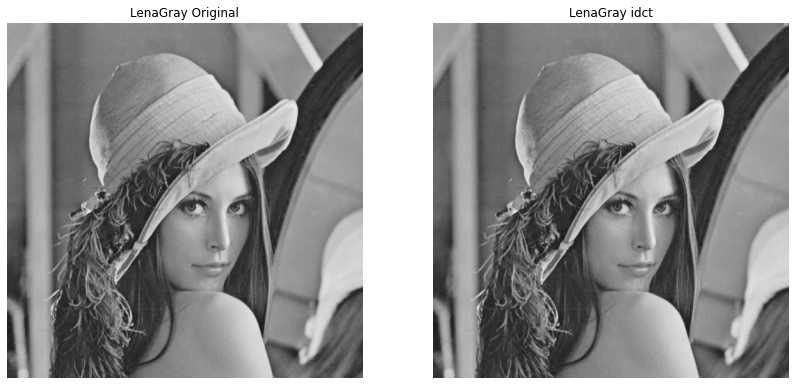

In [16]:
plt.figure(figsize=(14,7))
plt.subplot(121) #linhas,colunas,escolha entre 1 dos 2 (121)
plt.title('LenaGray Original')
plt.imshow(lena_gray, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.title('LenaGray idct')
plt.imshow(idct_teste,cmap='gray', vmin=0, vmax=255)
plt.axis('off')

---

### Exercício 2
Construa uma função (codificador) que para cada bloco de 8 × 8 de coeficientes da transformação efectuada faça
a divisão pela matriz de quantificação (tabela K1 no anexo da norma) multiplicada por um factor de qualidade q
(ver função quality_factor do ficheiro Tabelas_jpeg.ipynb). Veja a imagem com o conjunto dos blocos após
a quantificação. Construa uma função (descodificador) que realize a operação inversa da quantificação.
Junte estas funções às já realizadas e verifique para diferentes fatores de qualidade qual a SNR e veja a imagem
descodificada.

In [17]:
def quantificacao(blocks, k1, quality):
    for j in range(len(blocks)):
        #para cada bloco vai se realizar a equação da quantificação
        blocks[j] = blocks[j] / (k1 * quality_factor(quality))
    return blocks

In [18]:
def desquantificacao(blocks, k1, quality):
    for j in range(len(blocks)):
        blocks[j] = blocks[j] * (k1 * quality_factor(quality))
    return blocks

### Testes ao ex 2 com quality=10

SNR qualidade 10: 22.046110283240687


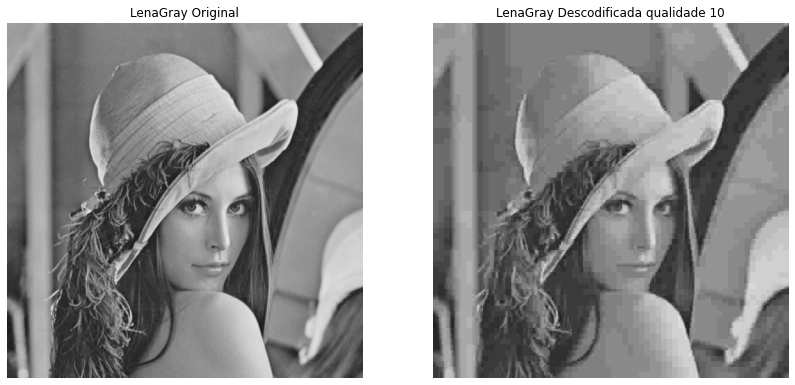

In [19]:
lena_gray = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
linhas, colunas = lena_gray.shape
lena_gray = lena_gray * 1.
quality =10
imagem = np.copy(lena_gray)

blocks = blocks_8x8(imagem)
dct_teste = dct(blocks)
quantificao_teste = quantificacao(dct_teste, Q, quality)
desquantificao_teste = desquantificacao(quantificao_teste, Q, quality)
idct_teste = convert_blocks8x8(idct(desquantificao_teste), linhas, colunas)
    
plt.figure(figsize=(14,7))
plt.subplot(121) #linhas,colunas,escolha entre 1 dos 2 (121)
plt.title('LenaGray Original')
plt.imshow(imagem, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.title('LenaGray Descodificada qualidade ' + str(quality))
plt.imshow(idct_teste,cmap='gray', vmin=0, vmax=255)
plt.axis('off')
    
print('SNR qualidade ' + str(quality) + ': ' + str(SNR(imagem, idct_teste)))

---

### Exercício 3
Construa uma função (codificador) que faça a codificação diferencial dos coeficientes DC após a quantificação.
Construa a função inversa para o descodificador.

Cada código DPCM (coeficiente DC) é representado pelo par
{Size, Amplitude}, de acordo com a tabela. O campo Size indica
quantos bits codificam o campo Amplitude.
O campo Size é codificado pelo algoritmo de Huffman.
(para valores negativos usa-se o complemento de 1)

o coeficiente DC representa o valor médio de brilho ou intensidade 
num bloco de pixeis da imagem.<br/>
Para cada bloco de uma imagem é possuido o seu coeficiente DC 

In [20]:
def dc(blocks):
    resultado = []
    dc_anterior = 0
    for j in range(len(blocks)):
        #vai buscar o bloco atual da imagem
        bloco_atual = blocks[j]
        #e para cada valor desse bloco
        dc_nova = bloco_atual[0][0]
        #faz-se a subtração com o valor anterior e adiciona-se ao array
        resultado.append(dc_nova - dc_anterior)
        #novo valor dc anterior
        dc_anterior = dc_nova - dc_anterior
        #limite de valores para a imagem com o dc para no máximo +-(2**10)-->amplitude
        if dc_anterior < -1023:
            dc_anterior = -1023
        if dc_anterior > 1023:
            dc_anterior = 1023
    return resultado

In [21]:
def idc(blocks):
    #array de resultado
    resultado = []
    
    for j in range(len(blocks)-1, -1, -1):
        #valor dc anterior
        dc_anterior = blocks[j-1]
        #se o indice for 0 o valor vai ser 0 também pela sua inixistencia
        if j == 0:
            dc_anterior = 0
        #adicionar o novo valor ao resultado
        resultado.append(blocks[j] + dc_anterior)
    #reverse da ordem do array para ficar igual ao original
    return resultado[::-1]

---

### Exercício 4
Construa uma função (codificador) que crie um array com a indexação em zig-zag dos coeficientes AC após a
quantificação e crie um array com os pares (zero run length, nonzero value).
Construa a função inversa para o descodificador.

Após a quantificação, muitos coeficientes de frequência tornam-se 0 ou próximos de 0. É aqui que é aplicado o Zero Run Length que explora este facto, na medida em que varre, em zig-zag, os coeficieintes de cada bloco e cnota o número de zeros consecutivos encontrados, antes de encontrar um coeficiente não zero.  

Ex: 
[5, 2, 1, 0, 0, 0, -1, 0, 0, 2] -> 
{0, 5}, {0, 2}, {0, 2}, {3, -1}, {2, 2}, {0, 0} 

In [22]:
def ac(blocks):
    ult_index = 0  # indice para saber onde não é zero
    # array resultado
    resultado = []  
    
    for j in range(len(blocks)):
        #array para guardar o ultimo bloco
        final_block = []  
        
        # aplicar zigzag ao bloco atual
        array_zigzag = aplicar_zigzag(blocks[j], ind_zz)
        #contador de zeros
        count_zeros = 0  
        
        for k in range(len(array_zigzag) - 1, 1, -1):
            if array_zigzag[k] != 0:
                #atualizar o ultimo bloco que não é igual a 0
                ult_index = k+1  
                break
        for k in range(1, ult_index, 1):
            if array_zigzag[k] == 0:
                #contador de zeros
                count_zeros += 1  
                #se houver 16 zeros adicionar (15,0) ao bloco final e reset ao contador de zeros
                if count_zeros > 15:  
                    final_block.append((15, 0)) 
                    count_zeros = 0
            else:
                # quando o número não é zero adiciona-se ao bloco o valor do contador de zeros
                # e o array_zigzag do bloco atual
                final_block.append((count_zeros, array_zigzag[k]))
                count_zeros = 0

        # adicionar (0,0) ao final do ultimo bloco
        final_block.append((0, 0))  
        # adicionar o bloco ao array resultado
        resultado.append(final_block)  
    
    return resultado

In [23]:
def iac(blocks):
    #array resultado
    resultado = []
    for j in range(len(blocks)):
        #array para guardar o ultimo bloco
        final_block = []
        #adicinar um valor inicial ao array
        final_block.append(0)
        bloco = blocks[j]
        for t in bloco:
            if t == (0,0):
                break
            zeros = t[0]
            val = t[1]
            for z in range(zeros):
                final_block.append(0)
            final_block.append(val)
        while (len(final_block) < 65):
            final_block.append(0)
        #adicionar o array sem estar em zigzag ao array resultado
        resultado.append(desfazer_zigzag(np.array(final_block), ind_zz))
    return np.array(resultado)


---

### Exercício 5
Junte estas funções às já realizadas e veja a imagem descodificada.

SNR -> 22.038786761306145 para Qualidade = 10
SNR -> 26.597511394043792 para Qualidade = 30
SNR -> 28.193926928087727 para Qualidade = 50
SNR -> 27.948405140262835 para Qualidade = 70


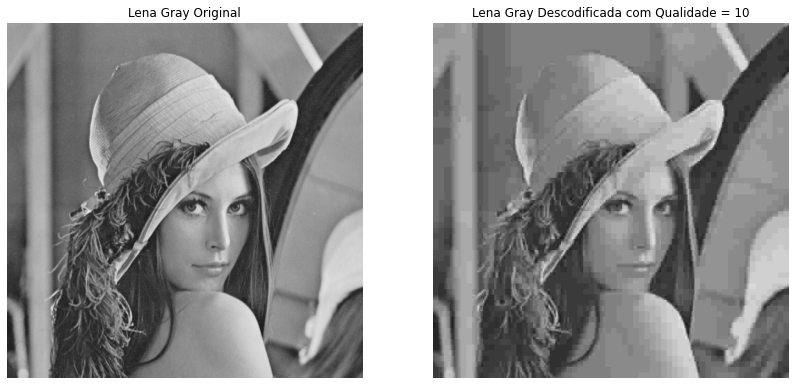

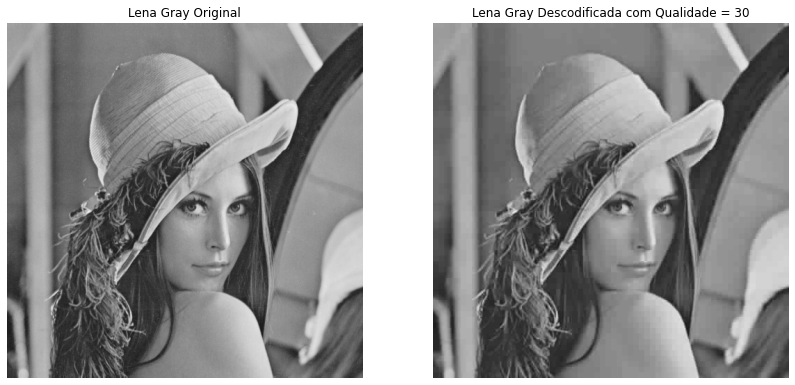

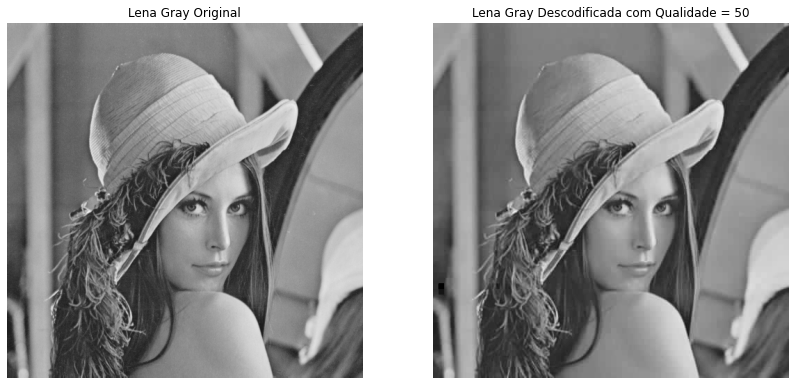

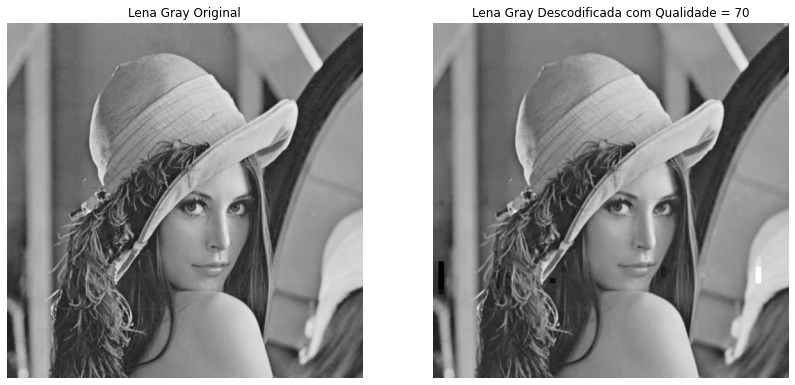

In [24]:
lena_gray = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE) * 1.

qualidades = [10,30,50,70]

for qualidade in qualidades:
    # Copiar imagem para mantera estrutura da imagem original
    img = np.copy(lena_gray)
    
    # Converter para blocos 8x8
    blocks = blocks_8x8(imagem)
    
    # Efetuar dct
    dct_img = dct(blocks)
    
    # Aplicar quantificação
    quant = quantificacao(dct_img, Q, qualidade)
    
    # Codificação dos Coeficientes AC e DC
    dc_img = dc(quant)
    ac_img = ac(quant)
    
    # Codificação inversa dos Coeficientes AC e DC
    idc_img = idc(dc_img)
    iac_img = iac(ac_img)
    
    # Juntar AC e DC
    iac_idc = np.copy(iac_img)
    for i in range(len(iac_img)):
        iac_idc[i][0][0] = idc_img[i]
    
    desquant = desquantificacao(iac_idc, Q, qualidade)
    idct_img = convert_blocks8x8(idct(desquant), img.shape[0], img.shape[1])
    
    plt.figure(figsize=(14,7))
    plt.subplot(121) #linhas,colunas,escolha entre 1 dos 2 (121)
    plt.title('Lena Gray Original')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Lena Gray Descodificada com Qualidade = ' + str(qualidade))
    plt.imshow(idct_img,cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    
    print('SNR -> ' + str(SNR(img, idct_img)) + ' para Qualidade = ' + str(qualidade))


### Exercício 6
Construa uma função que dados os arrays das alíneas anteriores use as tabelas do código de Huffman (tabela K3
e K5) e grave num ficheiro a sequência de bits correspondente. (não é necessário usar o formato JFIF)

In [25]:
def complemento(value):
    # Verifica se o valor é não negativo
    if(value >= 0):
        # Retorna a representação binária do valor não negativo
        return np.binary_repr(value)
    else:     # Valor é negativo
        value = abs(value) 
        len_value = len(np.binary_repr(value)) # Obtém o comprimento da representação binária
        aux = int('1' * len_value, 2) # Cria uma máscara com todos os bits iguais a 1 com o mesmo comprimento
        
        return np.binary_repr(value ^ aux, len_value)
def inv_complemento(value):
    if value[0] == '0': # se começar com 0 é negativo
        len_value = len(value)
        aux = int('1' * len_value, 2)
        
        return - (int(value,2) ^ aux)
    return int(value,2)

def cod_dc_ac(array_dc, array_ac):
    final = ""
    array_dc = np.clip(array_dc, -2047, 2047)
    for j in range(len(array_ac)):
        # dc em binario
        dc_bin = complemento(array_dc[j])
        
        # len bin
        len_bin = len(dc_bin)
        
        #K3(len)
        cod_k3 = K3[len_bin]
        if(dc_bin == '0'):
            cod_k3 = '00'
            
        final += cod_k3
        
        if(len_bin>0 and cod_k3 != '00'):
            final += dc_bin
            
        #AC
        for t in array_ac[j]: 
            
            t1 = t[1]
            comp_t1 = complemento(t1) #t1 binario
            bits_t1 = len(comp_t1)
            if(t1 == 0):
                bits_t1 = 0
            
            if (bits_t1 > 10):
                comp_t1 = complemento(1023)
                bits_t1 = 10
                
            final += K5[t[0], bits_t1] 
            
            if t1 != 0:
                final += comp_t1
    return final

def write2file(filename, shape, q, array_dc, array_ac):
    #escrever = bitstuffing, shape img 4 bytes, q, dc_ac
    seq_bits = ""
    seq_bits += np.binary_repr(shape[0], 16) + np.binary_repr(shape[1], 16) #cod da shape[0] e shape[1] -> 16 bits * 2
    seq_bits += np.binary_repr(q, 8) #cod fator qualidade q -> 8 bits (seriam 7 mas 8 poupa bitstuffing) 
    seq_bits += cod_dc_ac(array_dc, array_ac)
    
    seq_final = bit_stuffing(seq_bits)
    
    # Dividir de 8 em 8 bits
    mensagem_byte = re.findall('[01]{8}', seq_final)
    
    # Passar cada byte para int
    final = np.array([int(s,2)for s in mensagem_byte], dtype = 'uint8')
    
    f = open(filename, 'wb')
    f.write(final)
    f.close()

### Exercício 7
 Construa uma função que leia o ficheiro gravado e retorne os arrays com os coeficientes AC e DC.

In [26]:
def descod_dc_ac(seq_bits):
    dc = []
    ac_final = []
    
    # Inverter Dicionários
    k3_inverse = {v:k for k, v in K3.items()}
    k5_inverse = {v:k for k, v in K5.items()}

    cod_dc = ""
    cod_ac = ""
    
    i = 0
    j = 0
    while j < len(seq_bits):
        #DC
        cod_dc += seq_bits[j]
        if (cod_dc in k3_inverse):
            size = k3_inverse[cod_dc]
            if size == 0:
                dc.append(0)
            else:
                coeficiente_dc = seq_bits[j + 1:j+size + 1]
                dc.append(inv_complemento(coeficiente_dc))
            cod_dc = ''
            
            #AC
            i = j + 1 + size
            ac = []
            while i < len(seq_bits):
                cod_ac += seq_bits[i]
                
                if(cod_ac == '1010'): #eob
                    ac.append(k5_inverse[cod_ac])
                    cod_ac = ""
                    break
                    
                if(cod_ac in k5_inverse):
                    tuplo = k5_inverse[cod_ac]
                    len_bin = tuplo[1]
                    cod_int = 0
                    if (len_bin > 0):
                        t1_cod = seq_bits[i+1 : i+len_bin+1]
                        cod_int = inv_complemento(t1_cod)
                        
                    ac.append((tuplo[0], cod_int))
                    cod_ac = ""
                    i += len_bin
                    
                i += 1 # incrementa o i a cada iteração
            j = i # jump do j para o i após ac
            ac_final.append(ac)
        j += 1 # incrementa o j a cada iteração
    return dc, ac_final
    
def read_file(filename):
    
    f = open(filename, 'rb')
    mensagem = f.read()
    int2bin = np.array([format(i, '08b') for i in mensagem]) # bytes binary
    string_msg = "".join(int2bin) # binary string
    
    # Remoção do bit stuffing
    len_bitstuff = int(string_msg[:3], 2) 
    string_msg = string_msg[3+len_bitstuff::]
    
    linhas = int(string_msg[:16], 2) # 1 byte-> linhas
    colunas = int(string_msg[16:32], 2) # 1 byte-> colunas
    string_msg = string_msg[32::] # remoção dos 2 bytes da shape
    
    fator_qualidade = int(string_msg[:8], 2) # 1 byte -> fator de qualidade
    string_msg = string_msg[8::] # remover byte -> fica com a sequencia binária dc/ac
    seq_dc, seq_ac = descod_dc_ac(string_msg) 
    
    f.close()
    
    return (linhas, colunas, fator_qualidade, seq_dc, seq_ac)

# Exercicio 8 - Testes

Qualidade -> 10
Size Original: 210122
Size Decomp: 74178
SNR ->  -8.378012599613408
time cod ->  0.07
time decod ->  0.08
Taxa de Compressão ->  2.832672760117555
Qualidade -> 30
Size Original: 210122
Size Decomp: 133892
SNR ->  3.929875374319885
time cod ->  0.07
time decod ->  0.08
Taxa de Compressão ->  1.5693394676306276
Qualidade -> 50
Size Original: 210122
Size Decomp: 162768
SNR ->  12.36652154526962
time cod ->  0.07
time decod ->  0.08
Taxa de Compressão ->  1.290929421016416
Qualidade -> 70
Size Original: 210122
Size Decomp: 153290
SNR ->  27.948336191683218
time cod ->  0.07
time decod ->  0.08
Taxa de Compressão ->  1.370748254941614


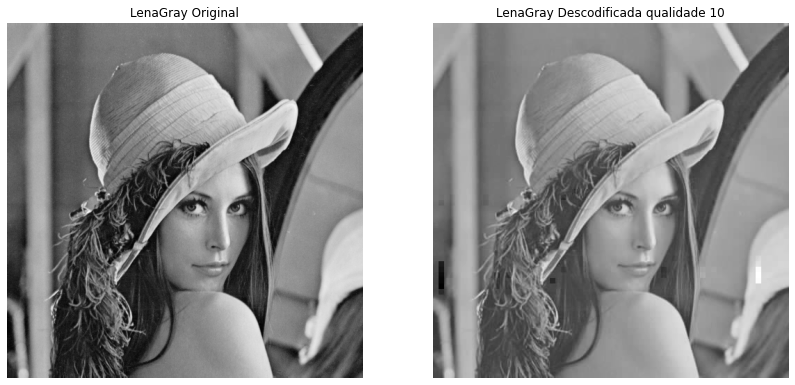

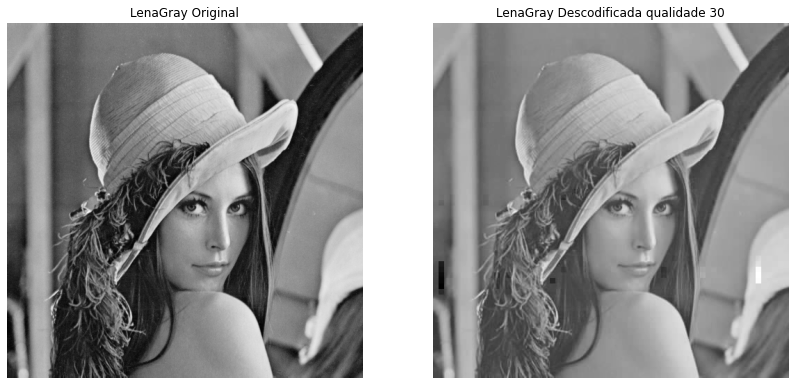

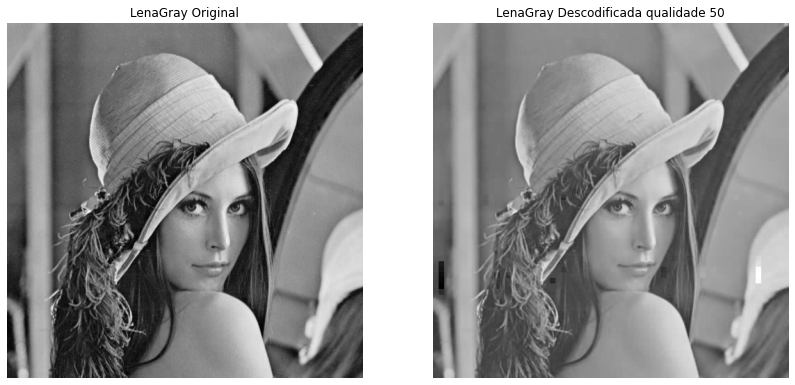

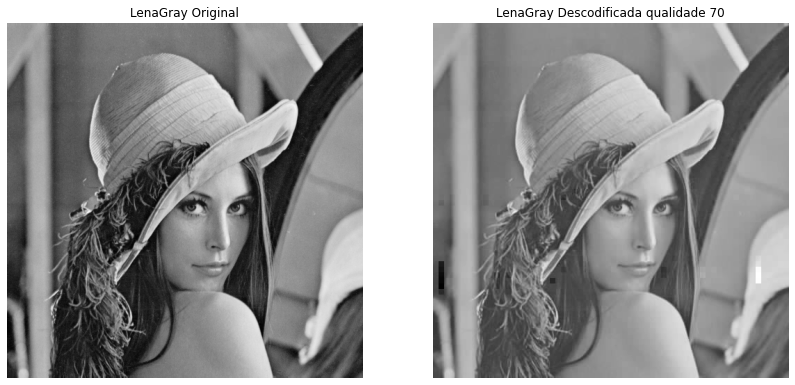

In [44]:
snr = []
tc  = []
tempo_c = []
tempo_d = []
sizes_deco = []

for qualidade in qualidades:
    print('Qualidade -> '+str(qualidade))
    img = np.copy(lena_gray)
    blocks = blocks_8x8(img)
    
    dct_img = dct(blocks)
    quantif = quantificacao(dct_img, Q, qualidade)
    dc_img = dc(quant)
    ac_img = ac(quant)
    
    time0 = time()
    write2file('lena_bin.b', img.shape, qualidade, dc_img, ac_img)
    time1 = time()
    time_cod = float("{:.2f}".format(time1-time0))
    
    linhas, colunas, qf, dc_seq, ac_seq = read_file('lena_bin.b')
    time2 = time()
    time_decod = float("{:.2f}".format(time2-time1))
  
    idc_img = idc(dc_seq)
    iac_img = iac(ac_seq)
    
    
    # Juntar AC e DC
    iac_idc_img = np.copy(iac_img)
    for i in range(len(iac_img)):
        iac_idc_img[i][0][0] = idc_img[i]

    desquant = desquantificacao(iac_idc_img, Q, qf)
    idct_img = convert_blocks8x8(idct(desquant), linhas, colunas)
    img_decomp = cv2.imwrite('lena_decomp.tif',idct_img)
    
    plt.figure(figsize=(14,7))
    plt.subplot(121) #linhas,colunas,escolha entre 1 dos 2 (121)
    plt.title('LenaGray Original')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.title('LenaGray Descodificada qualidade ' + str(qualidade))
    plt.imshow(idct_img,cmap='gray')
    plt.axis('off')
        
    print('Size Original: ' + str(os.path.getsize("LenaGray.tif")))
    print('Size Decomp: ' + str(os.path.getsize('lena_decomp.tif')))
    
    print('SNR -> ', SNR(img, idct_img))
    print('time cod -> ', time_cod)
    print('time decod -> ', time_decod)
    print('Taxa de Compressão -> ', comp_rate("LenaGray.tif", 'lena_decomp.tif'))
    size_deco = os.path.getsize('lena_decomp.tif')
    snr.append(SNR(img, idct_img))
    tc.append(comp_rate("LenaGray.tif", 'lena_decomp.tif'))
    tempo_c.append(time_cod)
    tempo_d.append(time_decod)
    sizes_deco.append(size_deco)

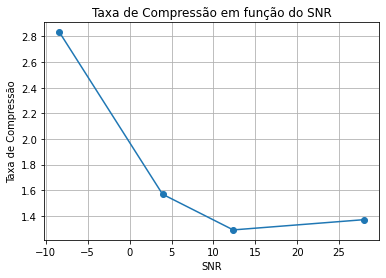

In [41]:
plt.plot(snr, tc, marker='o')
plt.xlabel('SNR')
plt.ylabel('Taxa de Compressão')
plt.title('Taxa de Compressão em função do SNR')
plt.grid(True)
plt.show()

In [42]:
import pandas as pd

data = {
    "Qualidade": qualidades,
    "Tempo de Codificação": tempo_c,
    "Tempo de Descodificação": tempo_d,
    "SNR": snr,
    "Taxa de Compressão": tc,
    "Tamanho Final": sizes_deco
}

df = pd.DataFrame(data)

df

,Qualidade,Tempo de Codificação,Tempo de Descodificação,SNR,Taxa de Compressão,Tamanho Final
0,10,0.07,0.08,-8.378013,2.832673,74178
1,30,0.07,0.08,3.929875,1.569339,133892
2,50,0.07,0.08,12.366522,1.290929,162768
3,70,0.07,0.08,27.948336,1.370748,153290
